In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import torchmetrics as tm
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys,os

from portfolios.portfolio_new import Portfolio

Device: cpu
Epochs: 100
Random seed set at: 21


In [3]:
resultsPath = '../saved/results_old/'

In [4]:
GuEnsemblePath = resultsPath + 'GuEnsemble/'
predicted_ret_path = GuEnsemblePath + 'predicted_returns/'
trial_info_path = GuEnsemblePath + 'trial_info/'

In [5]:
predicted_ret_files = [f for f in listdir(predicted_ret_path) if isfile(join(predicted_ret_path, f))]
trial_info_files = [f for f in listdir(trial_info_path) if isfile(join(trial_info_path, f))]

In [40]:
# # Turnover calculation

# df = pd.read_csv(predicted_ret_path + predicted_ret_files[0], index_col=0)
# port = Portfolio(df)

# df = port.weights_df[['permno', 'yyyymm','ret', 'predicted_ret','decile','weight', 'vw_ret']].copy()
# df = df.sort_values(by=['permno','yyyymm'])
# df['ret'] = df['ret']/100

# # Calculate needed metrics
# df['w_t+1'] = df.groupby('permno')['weight'].shift(-1)
# df['ret_t+1'] = df.groupby('permno')['ret'].shift(-1)
# df['w_t-times-r_t+1'] = df.groupby(['permno','decile'], as_index=False).apply(lambda x: x['weight']*x['ret_t+1']).reset_index(drop=True)

# # Calculate the sum over all stocks in the denominator
# sum_over_j = df.groupby('yyyymm', as_index=False)['w_t-times-r_t+1'].sum()
# sum_over_j = sum_over_j.rename({'w_t-times-r_t+1': 'sum_over_j'}, axis=1)
# df = df.merge(sum_over_j, on=['yyyymm'])
# df['sum_over_j'] = df['sum_over_j'] + 1

# # Select portfolio
# df = df.loc[df['decile'] == 10]

# # Final calculation of turnover
# turnover = np.abs(df['w_t+1'] - ((df['weight'] * (1+df['ret_t+1'])/df['sum_over_j']))).sum()
# turnover = round(turnover,2)
# print(f'{turnover}%')

129.12%


In [8]:
df = pd.read_csv(predicted_ret_path + '/' + predicted_ret_files[0], index_col=0)
import models.neural_net.metric as metric
import data.data_preprocessing as dp

print(f'R2 with predicted_ret file: {metric.calc_r2(df)}')
crsp = dp.load_crsp()
df.drop('ret', axis=1, inplace=True)
df.merge(crsp[['permno','yyyymm','ret']], on=['permno','yyyymm'], how='left')
metric.calc_r2(df)

KeyError: ('permno', 'yyyymm', 'ret')

In [5]:
returns = pd.DataFrame()

for idx, file in enumerate(predicted_ret_files):
    df = pd.read_csv(predicted_ret_path + '/' + file, index_col=0)
    df = df.rename({'predicted_ret': 'predicted_ret_'+str(idx)}, axis=1)
    if idx == 0:
        # returns = returns.reindex(columns=df.columns.tolist())
        returns = pd.concat([returns, df], axis=1)

    else:
        returns = pd.concat([returns, df.iloc[:,-1]], axis=1)

In [6]:
returns['predicted_ret'] = returns.iloc[:,3:].mean(axis=1)

In [7]:
returns = returns[['permno','yyyymm','ret', 'predicted_ret']]

In [8]:
import torchmetrics
import torch

spear = torchmetrics.SpearmanCorrCoef()
spearman = spear(torch.tensor(returns['ret']),torch.tensor(returns['predicted_ret']))

/home/ge65cuw/anaconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [9]:
print(f'Spearman correlation coefficient: {spearman.item():.4f}')

Spearman correlation coefficient: 0.0767


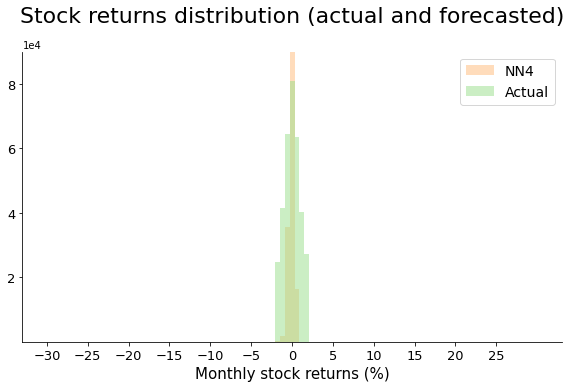

In [9]:
# Remove the plot frame lines. They are unnecessary chartjunk.
# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare  
# exception because of the number of lines being plotted on it.  
# Common sizes: (10, 7.5) and (12, 9)  
plt.figure(figsize=(8, 5.5))

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title("Stock returns distribution (actual and forecasted)\n", fontsize=22)


# Distribution of actual returns and predicted returns
bins = np.linspace(-30, 30, 100)
x1 = returns['predicted_ret']
x2 = returns['ret']
plt.hist(x1, bins, alpha=0.5, label='NN4', color=tableau20[3])
plt.hist(x2, bins, alpha=0.5, label='Actual', color=tableau20[5])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(range(-30, 30, 5), fontsize=13)
plt.yticks(range(0, 120000, 20000), fontsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.xlabel("Monthly stock returns (%)", fontsize=15)
plt.ylim(1, 90000)

plt.tight_layout()
plt.show()

# bbox_inches="tight" removes all the extra whitespace on the edges of your plot.
# plt.savefig("Returns_distribution.png", bbox_inches="tight")


# Portfolio calculation

In [11]:
portfolioVW = Portfolio(returns, weighting='VW')
# portfolioEW = Portfolio(returns, weighting='EW')

Loading the dataset...
Features stats:
Mean: -0.0	Std: 0.89	Median: 0.0
Weight columns = Index(['yyyymm', 'total_melag'], dtype='object')
   yyyymm  market_ret
0  197601    0.000000
1  197602    0.275002
2  197603    2.782108
3  197604   -1.059692
4  197605   -0.914437
IR & alpha calculation...
Params
const     1.585319
Mkt-RF   -0.042643
SMB      -0.456151
HML       0.284871
RMW       0.433332
CMA       0.338306
Mom       0.134050
ST_Rev   -0.125761
dtype: float64
tValues
const     6.466020
Mkt-RF   -0.664069
SMB      -5.523790
HML       2.765142
RMW       4.010977
CMA       2.253171
Mom       2.532449
ST_Rev   -1.865450
dtype: float64
Linear Regression summary:
                            OLS Regression Results                            
Dep. Variable:                    l-s   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     28.51
Date:       

In [15]:
pret = portfolioVW.returns

In [1]:
from portfolios.market_portfolio import MarketPortfolio
mp = MarketPortfolio()

Device: cpu
Epochs: 200
Random seed set at: 21
Creating the dataset...
Data pre-processing...
Merging returns information with signals...
Scaling features...
Index(['VolumeTrend', 'XFIN', 'zerotrade', 'zerotradeAlt1', 'zerotradeAlt12'], dtype='object')
Shape of final_df before scaling: 1359199
After scaling, the length is: 1048471
Loading the dataset...
Features stats:
Mean: -0.0	Std: 0.87	Median: 0.0
202112
202112
Weight columns = Index(['yyyymm', 'total_melag'], dtype='object')
   yyyymm  market_ret
0  197001    0.000000
1  197002    5.842420
2  197003   -0.339433
3  197004  -10.218710
4  197005   -6.267181


In [1]:
mkt = mp.mkt_returns
pret = pret.merge(mkt, on='yyyymm', how='left')

NameError: name 'mp' is not defined

,yyyymm,market_ret
0,197601,0.000000
1,197602,0.275002
2,197603,2.782108
3,197604,-1.059692
4,197605,-0.914437
...,...,...
535,202008,6.793989
536,202009,-3.341652
537,202010,-1.552484
538,202011,11.900663


In [18]:
T = pret.count()[1]
alpha_market_long = ((((pret.iloc[:,-3] - pret.iloc[:,-1])/100+1)**(12/T)).prod())-1
alpha_market_long_short = ((((pret.iloc[:,-2] - pret.iloc[:,-1])/100+1)**(12/T)).prod())-1
        

In [30]:
(((pret.iloc[:,-2] - pret.iloc[:,-1])/100+1)**(12/T)).prod()

1.066721509722535

In [20]:
alpha_market_long_short

0.0667215097225351

Loading the dataset...
Weight columns = Index(['yyyymm', 'total_melag'], dtype='object')
   yyyymm  market_ret
0  197601    0.000000
1  197602    0.275002
2  197603    2.782108
3  197604   -1.059692
4  197605   -0.914437


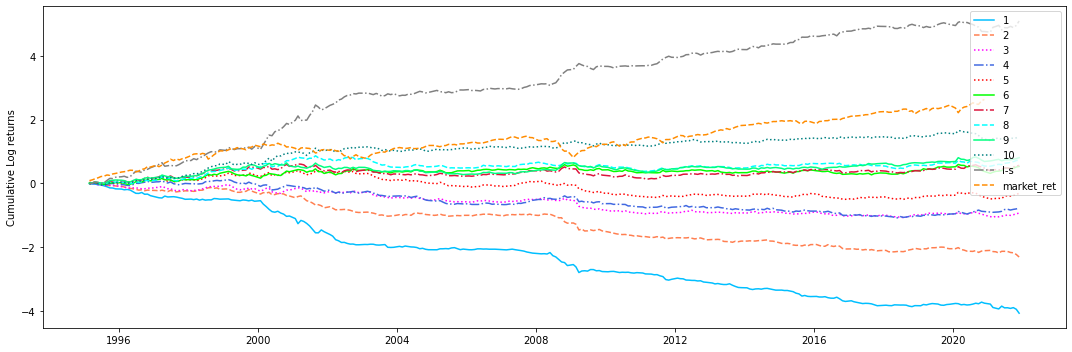

In [12]:
portfolioVW.plot_cumulative_returns(path=None)

In [13]:
portfolioVW.regress_on_FF5FM(method='long')

IR & alpha calculation...
Params
const     0.570426
Mkt-RF   -0.020665
SMB      -0.697060
HML       0.079298
RMW       0.028033
CMA       0.132227
Mom       0.100550
ST_Rev   -0.090972
dtype: float64
tValues
const      4.214199
Mkt-RF    -0.582912
SMB      -15.289520
HML        1.394206
RMW        0.469999
CMA        1.595145
Mom        3.440758
ST_Rev    -2.444222
dtype: float64
Linear Regression summary:
                            OLS Regression Results                            
Dep. Variable:                     10   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     56.30
Date:                Sat, 22 Oct 2022   Prob (F-statistic):           2.37e-50
Time:                        11:59:26   Log-Likelihood:                -640.37
No. Observations:                 296   AIC:                             1297.
Df Residuals:                     288

In [14]:
portfolioVW._calculate_metrics()

Average return:
	Long: 0.55%	Long-short: 1.85%
T is 296
Annualized returns:
	Long: 6.11%	Long-short:22.94%
Standard deviation on returns:
	Long: 3.24	Long-short:4.96
Sharpe ratio:
	Long: 1.89	Long-short:4.62
Loading the dataset...
Weight columns = Index(['yyyymm', 'total_melag'], dtype='object')
   yyyymm  market_ret
0  197601    0.000000
1  197602    0.275002
2  197603    2.782108
3  197604   -1.059692
4  197605   -0.914437
     yyyymm  market_ret
0    197601    0.000000
1    197602    0.275002
2    197603    2.782108
3    197604   -1.059692
4    197605   -0.914437
..      ...         ...
535  202008    6.793989
536  202009   -3.341652
537  202010   -1.552484
538  202011   11.900663
539  202012    4.282958

[540 rows x 2 columns]
